Training: (3936, 134), Validation: (984, 134)
Target classes: 41
Original feature count: 134
FEATURE SELECTION ANALYSIS
Chi2 selected features: 50
Mutual Info selected features: 50
Running RFE (this may take a few minutes)...
RFE selected features: 64 (optimal)
Lasso selected features: 121

Top 20 Consensus Features:


,feature,vote_count,methods
30,abnormal_menstruation,4,"Chi2, Mutual_Info, RFE, Lasso"
26,depression,4,"Chi2, Mutual_Info, RFE, Lasso"
49,symptom_count,4,"Chi2, Mutual_Info, RFE, Lasso"
20,muscle_weakness,4,"Chi2, Mutual_Info, RFE, Lasso"
53,chills,3,"Mutual_Info, RFE, Lasso"
1,pain_behind_the_eyes,3,"Chi2, RFE, Lasso"
62,cough,3,"Mutual_Info, RFE, Lasso"
59,weight_loss,3,"Mutual_Info, RFE, Lasso"
57,fatigue,3,"Mutual_Info, RFE, Lasso"
54,joint_pain,3,"Mutual_Info, RFE, Lasso"



Final consensus features: 98
Feature reduction: 134 → 98
Comparing All Features vs Selected Features...

Feature Selection Impact:
All features (134): 1.0000±0.0000
Selected features (98): 1.0000±0.0000
CHAMPION MODEL TRAINING

XGBoost Results:
Train Accuracy: 1.0000
Valid Accuracy: 1.0000
CV Mean±Std: 0.9995±0.0010
Training time: 87.15s

LightGBM Results:
Train Accuracy: 1.0000
Valid Accuracy: 1.0000
CV Mean±Std: 1.0000±0.0000
Training time: 34.46s

CatBoost Results:
Train Accuracy: 1.0000
Valid Accuracy: 1.0000
CV Mean±Std: 1.0000±0.0000
Training time: 104.26s

Random Forest Results:
Train Accuracy: 0.9964
Valid Accuracy: 0.9959
CV Mean±Std: 0.9990±0.0015
Training time: 3.01s

Top 3 models for ensemble:
LightGBM: CV=1.0000
CatBoost: CV=1.0000
XGBoost: CV=0.9995

Voting Ensemble Results:
Train Accuracy: 1.0000
Valid Accuracy: 1.0000
CV Mean±Std: 1.0000±0.0000
Training time: 281.78s

FINAL MODEL COMPARISON:
XGBoost             : 1.0000
LightGBM            : 1.0000
CatBoost            

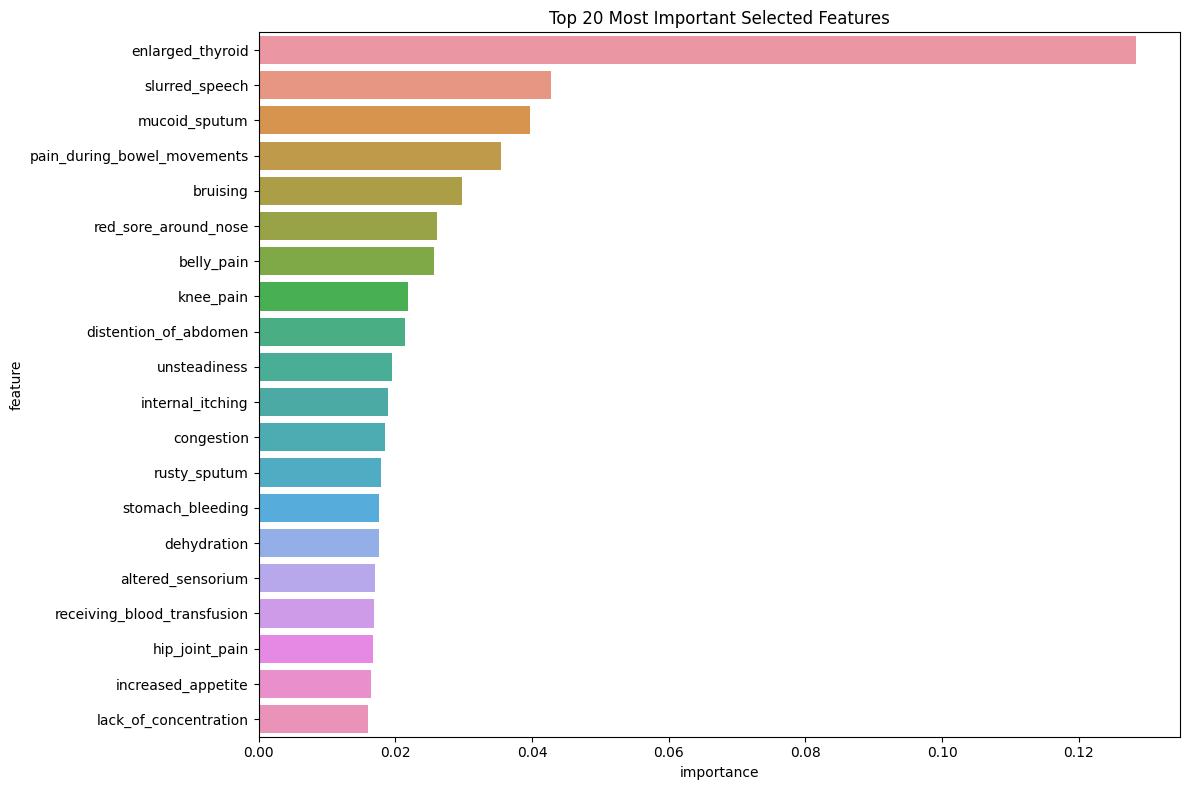

Top 10 Most Important Features:


,feature,importance
97,enlarged_thyroid,0.128361
93,slurred_speech,0.042836
51,mucoid_sputum,0.039683
42,pain_during_bowel_movements,0.035523
50,bruising,0.029753
83,red_sore_around_nose,0.026141
49,belly_pain,0.025607
44,knee_pain,0.021913
20,distention_of_abdomen,0.021442
75,unsteadiness,0.019545



🚀 READY FOR FLASK DEPLOYMENT!


In [2]:
# ======================================================================
# model_training.ipynb  |  Disease-Prediction Mini-Hackathon  
# COMPLETE PIPELINE: Data Loading → Feature Selection → Champion Models
# ======================================================================

# %% [markdown]
# # 1. Setup & Configuration

# %%
import os, warnings, logging, joblib, time
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path

# ML Libraries
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import (
    SelectKBest, chi2, mutual_info_classif, RFE, RFECV, SelectFromModel
)
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb, lightgbm as lgb, catboost as cb

warnings.filterwarnings("ignore")
SEED = 42
np.random.seed(SEED)

# Paths
ROOT = Path.cwd().parent if Path.cwd().name.lower()=="notebook" else Path.cwd()
PROC = ROOT / "data" / "processed" 
MODELS = ROOT / "models"
MODELS.mkdir(exist_ok=True)

# %% [markdown]
# # 2. Data Loading

# %%
# Load processed data
X_train = pd.read_csv(PROC / "X_train.csv")
y_train = pd.read_csv(PROC / "y_train.csv").squeeze()
X_valid = pd.read_csv(PROC / "X_valid.csv") 
y_valid = pd.read_csv(PROC / "y_valid.csv").squeeze()

print(f"Training: {X_train.shape}, Validation: {X_valid.shape}")
print(f"Target classes: {len(np.unique(y_train))}")
print(f"Original feature count: {X_train.shape[1]}")

# %% [markdown]
# # 3. Advanced Feature Selection Pipeline

# %%
print("=" * 60)
print("FEATURE SELECTION ANALYSIS")
print("=" * 60)

# Method 1: Statistical Tests (Chi2)
chi2_selector = SelectKBest(chi2, k=50)  # Top 50 features
chi2_selector.fit(X_train, y_train)
chi2_features = X_train.columns[chi2_selector.get_support()].tolist()
print(f"Chi2 selected features: {len(chi2_features)}")

# Method 2: Mutual Information
mi_selector = SelectKBest(mutual_info_classif, k=50)
mi_selector.fit(X_train, y_train)
mi_features = X_train.columns[mi_selector.get_support()].tolist()
print(f"Mutual Info selected features: {len(mi_features)}")

# Method 3: Recursive Feature Elimination with Random Forest
print("Running RFE (this may take a few minutes)...")
rf_temp = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)
rfe_selector = RFECV(rf_temp, step=5, cv=3, scoring='accuracy', n_jobs=-1)
rfe_selector.fit(X_train, y_train)
rfe_features = X_train.columns[rfe_selector.support_].tolist()
print(f"RFE selected features: {len(rfe_features)} (optimal)")

# Method 4: L1-based Selection (Lasso)
lasso_selector = SelectFromModel(
    LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=SEED, max_iter=1000)
)
lasso_selector.fit(X_train, y_train)
lasso_features = X_train.columns[lasso_selector.get_support()].tolist()
print(f"Lasso selected features: {len(lasso_features)}")

# %% [markdown]
# ## Feature Selection Consensus

# %%
# Find consensus features (appear in multiple methods)
feature_votes = {}
all_selected = [chi2_features, mi_features, rfe_features, lasso_features]
method_names = ['Chi2', 'Mutual_Info', 'RFE', 'Lasso']

for features, method in zip(all_selected, method_names):
    for feature in features:
        if feature not in feature_votes:
            feature_votes[feature] = []
        feature_votes[feature].append(method)

# Create consensus ranking
consensus_df = pd.DataFrame([
    {'feature': feat, 'vote_count': len(methods), 'methods': ', '.join(methods)}
    for feat, methods in feature_votes.items()
]).sort_values('vote_count', ascending=False)

print("\nTop 20 Consensus Features:")
display(consensus_df.head(20))

# Select final feature set (features voted by 2+ methods)
final_features = consensus_df[consensus_df.vote_count >= 2]['feature'].tolist()
print(f"\nFinal consensus features: {len(final_features)}")

# Apply feature selection
X_train_selected = X_train[final_features]
X_valid_selected = X_valid[final_features]

print(f"Feature reduction: {X_train.shape[1]} → {X_train_selected.shape[1]}")

# %% [markdown]
# ## Evaluate Impact of Feature Selection

# %%
# Quick comparison: All features vs Selected features
rf_all = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)
rf_selected = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)

# Cross-validation comparison
print("Comparing All Features vs Selected Features...")
cv_all = cross_val_score(rf_all, X_train, y_train, cv=5, n_jobs=-1)
cv_selected = cross_val_score(rf_selected, X_train_selected, y_train, cv=5, n_jobs=-1)

print("\nFeature Selection Impact:")
print(f"All features ({X_train.shape[1]}): {cv_all.mean():.4f}±{cv_all.std():.4f}")
print(f"Selected features ({X_train_selected.shape[1]}): {cv_selected.mean():.4f}±{cv_selected.std():.4f}")

# Use selected features for final modeling
X_train_final = X_train_selected
X_valid_final = X_valid_selected

# %% [markdown]
# # 4. Champion Model Training

# %%
def evaluate_model(model, X_tr, y_tr, X_val, y_val, name):
    """Train and evaluate a single model"""
    start_time = time.time()
    model.fit(X_tr, y_tr)
    
    # Predictions
    train_pred = model.predict(X_tr)
    valid_pred = model.predict(X_val)
    
    # Metrics
    train_acc = accuracy_score(y_tr, train_pred)
    valid_acc = accuracy_score(y_val, valid_pred)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_tr, y_tr, cv=5, scoring='accuracy', n_jobs=-1)
    
    print(f"\n{name} Results:")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Valid Accuracy: {valid_acc:.4f}")
    print(f"CV Mean±Std: {cv_scores.mean():.4f}±{cv_scores.std():.4f}")
    print(f"Training time: {time.time()-start_time:.2f}s")
    
    return model, valid_acc, cv_scores.mean()

print("=" * 60)
print("CHAMPION MODEL TRAINING")
print("=" * 60)

results = {}

# XGBoost - Optimized for selected features
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=SEED,
    n_jobs=-1
)
xgb_fitted, xgb_acc, xgb_cv = evaluate_model(xgb_model, X_train_final, y_train, X_valid_final, y_valid, "XGBoost")
results['XGBoost'] = {'model': xgb_fitted, 'accuracy': xgb_acc, 'cv': xgb_cv}

# LightGBM - Fast and accurate
lgb_model = lgb.LGBMClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    feature_fraction=0.8,
    random_state=SEED,
    n_jobs=-1,
    verbose=-1
)
lgb_fitted, lgb_acc, lgb_cv = evaluate_model(lgb_model, X_train_final, y_train, X_valid_final, y_valid, "LightGBM")
results['LightGBM'] = {'model': lgb_fitted, 'accuracy': lgb_acc, 'cv': lgb_cv}

# CatBoost - Handles features well
cb_model = cb.CatBoostClassifier(
    iterations=300,
    depth=6,
    learning_rate=0.1,
    random_state=SEED,
    verbose=False
)
cb_fitted, cb_acc, cb_cv = evaluate_model(cb_model, X_train_final, y_train, X_valid_final, y_valid, "CatBoost")
results['CatBoost'] = {'model': cb_fitted, 'accuracy': cb_acc, 'cv': cb_cv}

# Random Forest - Robust baseline
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=SEED,
    n_jobs=-1
)
rf_fitted, rf_acc, rf_cv = evaluate_model(rf_model, X_train_final, y_train, X_valid_final, y_valid, "Random Forest")
results['RandomForest'] = {'model': rf_fitted, 'accuracy': rf_acc, 'cv': rf_cv}

# %% [markdown]
# # 5. Ensemble Creation

# %%
# Create voting ensemble with top 3 models
best_models = sorted(results.items(), key=lambda x: x[1]['cv'], reverse=True)[:3]
print("\nTop 3 models for ensemble:")
for name, metrics in best_models:
    print(f"{name}: CV={metrics['cv']:.4f}")

voting_ensemble = VotingClassifier(
    estimators=[(name, metrics['model']) for name, metrics in best_models],
    voting='soft'  # Use probability averaging
)

# Train ensemble
voting_fitted, voting_acc, voting_cv = evaluate_model(
    voting_ensemble, X_train_final, y_train, X_valid_final, y_valid, "Voting Ensemble"
)

# %% [markdown]
# # 6. Final Model Selection & Saving

# %%
# Compare all models
final_results = {
    'XGBoost': results['XGBoost']['accuracy'],
    'LightGBM': results['LightGBM']['accuracy'],
    'CatBoost': results['CatBoost']['accuracy'],
    'RandomForest': results['RandomForest']['accuracy'],
    'Voting Ensemble': voting_acc
}

print("\n" + "="*50)
print("FINAL MODEL COMPARISON:")
print("="*50)
for name, acc in final_results.items():
    print(f"{name:20}: {acc:.4f}")

# Select champion model
champion_name = max(final_results.items(), key=lambda x: x[1])[0]
print(f"\n🏆 CHAMPION MODEL: {champion_name}")

# Get champion model
if champion_name == 'Voting Ensemble':
    champion_model = voting_fitted
else:
    champion_model = results[champion_name]['model']

# Save models and features
joblib.dump(champion_model, MODELS / "champion_model.pkl")
joblib.dump(final_features, MODELS / "selected_features.pkl")
consensus_df.to_csv(MODELS / "feature_selection_analysis.csv", index=False)

print("Champion model and features saved!")

# %% [markdown]
# # 7. Test Set Evaluation

# %%
# Load test data and apply same feature selection
test_df = pd.read_csv(PROC / "test_processed.csv")
X_test = test_df.drop('prognosis', axis=1)[final_features]  # Apply feature selection
y_test_true = test_df['prognosis']

# Generate predictions
test_predictions = champion_model.predict(X_test)
test_accuracy = accuracy_score(y_test_true, test_predictions)

print(f"\n🎯 FINAL RESULTS:")
print(f"Champion Model: {champion_name}")
print(f"Validation Accuracy: {max(final_results.values()):.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Features Used: {len(final_features)} / {X_train.shape[1]}")

# Save predictions for submission
submission_df = pd.DataFrame({'prediction': test_predictions})
submission_df.to_csv(ROOT / "predictions.csv", index=False)
print("Predictions saved to predictions.csv")

# %% [markdown]
# # 8. Feature Importance Analysis

# %%
if hasattr(champion_model, 'feature_importances_'):
    importance = champion_model.feature_importances_
elif hasattr(champion_model, 'estimators_'):
    importance = np.mean([est.feature_importances_ for est in champion_model.estimators_], axis=0)

if 'importance' in locals():
    feature_importance = pd.DataFrame({
        'feature': final_features,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(data=feature_importance.head(20), y='feature', x='importance')
    plt.title('Top 20 Most Important Selected Features')
    plt.tight_layout()
    plt.show()
    
    print("Top 10 Most Important Features:")
    display(feature_importance.head(10))

print(f"\n🚀 READY FOR FLASK DEPLOYMENT!")


🚀 Disease Prediction Model Training Pipeline
Training shape: (3936, 134)
Validation shape: (984, 134)
Unique diseases: 41
Original features: 134
Missing values in X_train: 0
Feature data types: {dtype('int64'): 134}

🔍 COMPREHENSIVE FEATURE SELECTION PIPELINE
Step 1: Removing low variance features...
   Features after variance filtering: 132 (removed 2)
Step 2: Chi-Square feature selection...
   Top Chi2 features selected: 60
Step 3: Mutual Information feature selection...
   Top Mutual Info features selected: 60
Step 4: Random Forest feature importance...
   Top Random Forest features selected: 60
Step 5: Recursive Feature Elimination (this may take a few minutes)...
   RFE optimal features: 97
Step 6: L1 Regularization feature selection...
   Lasso selected features: 66

📊 FEATURE SELECTION CONSENSUS ANALYSIS
Feature Selection Summary:
  Chi2           :  60 features
  Mutual_Info    :  60 features
  Random_Forest  :  60 features
  RFE            :  97 features
  Lasso          :  66

,feature,vote_count,methods,selection_rate
0,symptom_count,5,"Chi2, Mutual_Info, Random_Forest, RFE, Lasso",1.0
10,receiving_blood_transfusion,5,"Chi2, Mutual_Info, Random_Forest, RFE, Lasso",1.0
51,lack_of_concentration,5,"Chi2, Mutual_Info, Random_Forest, RFE, Lasso",1.0
38,muscle_weakness,5,"Chi2, Mutual_Info, Random_Forest, RFE, Lasso",1.0
37,red_spots_over_body,5,"Chi2, Mutual_Info, Random_Forest, RFE, Lasso",1.0
23,abnormal_menstruation,5,"Chi2, Mutual_Info, Random_Forest, RFE, Lasso",1.0
20,rusty_sputum,5,"Chi2, Mutual_Info, Random_Forest, RFE, Lasso",1.0
59,family_history,5,"Chi2, Mutual_Info, Random_Forest, RFE, Lasso",1.0
2,pain_behind_the_eyes,5,"Chi2, Mutual_Info, Random_Forest, RFE, Lasso",1.0
63,loss_of_appetite,4,"Mutual_Info, Random_Forest, RFE, Lasso",0.8



🎯 FINAL FEATURE SET: 93 features
Reduction: 134 → 93 (69.4% retained)

⚡ EVALUATING FEATURE SELECTION IMPACT
Running cross-validation comparison...
Feature Selection Impact:
  All features (134): 1.0000 ± 0.0000
  Selected     ( 93): 1.0000 ± 0.0000
  Improvement: +0.0000 (Worse)

💾 SAVING FEATURE SELECTION RESULTS
✅ Saved selected_features.pkl (93 features)
✅ Saved selected_features.csv
✅ Saved feature_selection_consensus.csv
✅ Saved feature_scores_by_method.csv
✅ Saved feature_selection_summary.json

🏆 CHAMPION MODEL TRAINING (Selected Features)
Training XGBoost...

XGBoost Results:
  Train Accuracy: 1.0000
  Valid Accuracy: 1.0000
  CV Mean ± Std:  0.9995 ± 0.0010
  Training time:  74.88s
Training LightGBM...

LightGBM Results:
  Train Accuracy: 1.0000
  Valid Accuracy: 1.0000
  CV Mean ± Std:  1.0000 ± 0.0000
  Training time:  33.46s
Training CatBoost...

CatBoost Results:
  Train Accuracy: 1.0000
  Valid Accuracy: 1.0000
  CV Mean ± Std:  1.0000 ± 0.0000
  Training time:  79.49s


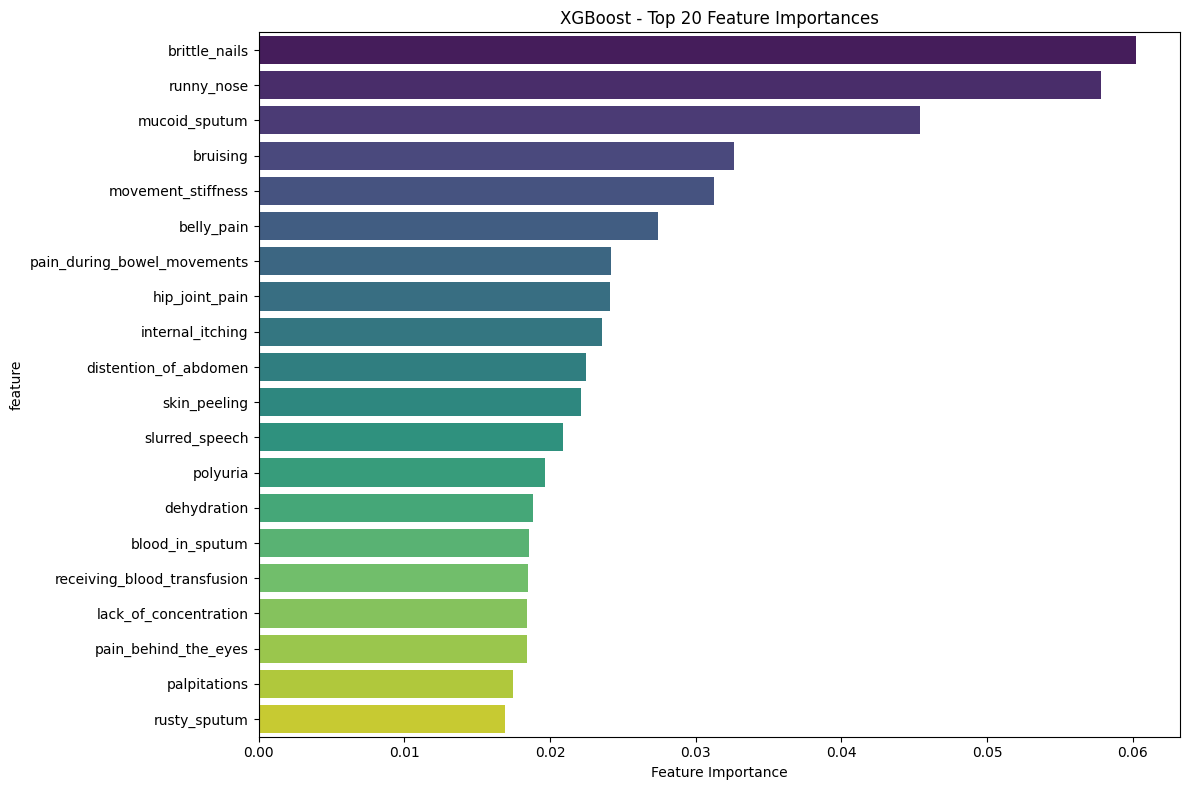

✅ Saved champion_feature_importance.csv

Top 10 Most Important Features:


,feature,importance
67,brittle_nails,0.060218
79,runny_nose,0.057783
43,mucoid_sputum,0.045403
70,bruising,0.032642
86,movement_stiffness,0.031274
40,belly_pain,0.027419
39,pain_during_bowel_movements,0.024202
61,hip_joint_pain,0.024121
44,internal_itching,0.023547
63,distention_of_abdomen,0.022479



🎉 HACKATHON MODEL TRAINING COMPLETE!
🏆 Champion Model: XGBoost
🎯 Test Accuracy: 0.9762
⚡ Features: 93 / 134 (69.4% reduction)
📊 Data: 3936 train, 984 valid, 42 test
📁 Models saved in: d:\Portfolio\disease\models/
📋 Predictions: predictions.csv

🚀 Ready for Flask deployment!


In [3]:
# ======================================================================
# model_training.ipynb  |  Disease-Prediction Mini-Hackathon
# COMPLETE PIPELINE: Feature Selection → Champion Models → Deployment Ready
# Author: <your name>   |  Python 3.10.11
# ======================================================================

# %% [markdown]
# # 1. Setup & Configuration

# %%
import os, sys, warnings, logging, joblib, time, json
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path

# ML Libraries
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import (
    SelectKBest, chi2, mutual_info_classif, 
    RFE, RFECV, SelectFromModel, VarianceThreshold
)
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb, lightgbm as lgb, catboost as cb

# Configuration
warnings.filterwarnings("ignore")
SEED = 42
np.random.seed(SEED)

# Paths
ROOT = Path.cwd().parent if Path.cwd().name.lower()=="notebook" else Path.cwd()
PROC = ROOT / "data" / "processed" 
MODELS = ROOT / "models"
MODELS.mkdir(exist_ok=True)

# Logging
logging.basicConfig(level=logging.INFO, format="%(levelname)s | %(message)s")

print("🚀 Disease Prediction Model Training Pipeline")
print("=" * 60)

# %% [markdown]
# # 2. Data Loading & Initial Exploration

# %%
# Load processed data
X_train = pd.read_csv(PROC / "X_train.csv")
y_train = pd.read_csv(PROC / "y_train.csv").squeeze()
X_valid = pd.read_csv(PROC / "X_valid.csv") 
y_valid = pd.read_csv(PROC / "y_valid.csv").squeeze()

print(f"Training shape: {X_train.shape}")
print(f"Validation shape: {X_valid.shape}")
print(f"Unique diseases: {len(np.unique(y_train))}")
print(f"Original features: {X_train.shape[1]}")

# Basic data quality check
print(f"Missing values in X_train: {X_train.isnull().sum().sum()}")
print(f"Feature data types: {X_train.dtypes.value_counts().to_dict()}")

# %% [markdown]
# # 3. Advanced Feature Selection Pipeline

# %%
print("\n" + "=" * 60)
print("🔍 COMPREHENSIVE FEATURE SELECTION PIPELINE")
print("=" * 60)

# Store original feature names
original_features = X_train.columns.tolist()
feature_selection_results = {}

# Method 1: Remove Low Variance Features
print("Step 1: Removing low variance features...")
variance_selector = VarianceThreshold(threshold=0.01)  # Remove features with <1% variance
X_train_var = variance_selector.fit_transform(X_train)
variance_features = X_train.columns[variance_selector.get_support()].tolist()
print(f"   Features after variance filtering: {len(variance_features)} (removed {X_train.shape[1] - len(variance_features)})")

# Update X_train for next steps
X_train_filtered = X_train[variance_features]

# Method 2: Chi-Square Statistical Test
print("Step 2: Chi-Square feature selection...")
chi2_selector = SelectKBest(chi2, k=min(60, len(variance_features)))
chi2_selector.fit(X_train_filtered, y_train)
chi2_scores = pd.DataFrame({
    'feature': variance_features,
    'chi2_score': chi2_selector.scores_,
    'chi2_pvalue': chi2_selector.pvalues_
}).sort_values('chi2_score', ascending=False)

chi2_features = chi2_scores.head(60)['feature'].tolist()
print(f"   Top Chi2 features selected: {len(chi2_features)}")

# Method 3: Mutual Information
print("Step 3: Mutual Information feature selection...")
mi_selector = SelectKBest(mutual_info_classif, k=min(60, len(variance_features)))
mi_selector.fit(X_train_filtered, y_train)
mi_scores = pd.DataFrame({
    'feature': variance_features,
    'mi_score': mi_selector.scores_
}).sort_values('mi_score', ascending=False)

mi_features = mi_scores.head(60)['feature'].tolist()
print(f"   Top Mutual Info features selected: {len(mi_features)}")

# Method 4: Random Forest Feature Importance
print("Step 4: Random Forest feature importance...")
rf_selector = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)
rf_selector.fit(X_train_filtered, y_train)
rf_importance = pd.DataFrame({
    'feature': variance_features,
    'rf_importance': rf_selector.feature_importances_
}).sort_values('rf_importance', ascending=False)

rf_features = rf_importance.head(60)['feature'].tolist()
print(f"   Top Random Forest features selected: {len(rf_features)}")

# Method 5: Recursive Feature Elimination with Cross-Validation
print("Step 5: Recursive Feature Elimination (this may take a few minutes)...")
rfe_estimator = ExtraTreesClassifier(n_estimators=50, random_state=SEED, n_jobs=-1)
rfe_selector = RFECV(
    estimator=rfe_estimator,
    step=5,
    cv=StratifiedKFold(3, shuffle=True, random_state=SEED),
    scoring='accuracy',
    n_jobs=-1
)
rfe_selector.fit(X_train_filtered, y_train)
rfe_features = X_train_filtered.columns[rfe_selector.support_].tolist()
print(f"   RFE optimal features: {len(rfe_features)}")

# Method 6: L1 Regularization (Lasso)
print("Step 6: L1 Regularization feature selection...")
lasso_selector = SelectFromModel(
    LogisticRegression(
        penalty='l1', 
        solver='liblinear', 
        C=0.1, 
        random_state=SEED,
        max_iter=1000
    ),
    threshold='median'
)
lasso_selector.fit(X_train_filtered, y_train)
lasso_features = X_train_filtered.columns[lasso_selector.get_support()].tolist()
print(f"   Lasso selected features: {len(lasso_features)}")

# %% [markdown]
# # 4. Feature Selection Consensus & Analysis

# %%
print("\n" + "=" * 60)
print("📊 FEATURE SELECTION CONSENSUS ANALYSIS")
print("=" * 60)

# Combine all feature selection results
all_selected_features = {
    'Chi2': chi2_features,
    'Mutual_Info': mi_features,
    'Random_Forest': rf_features,
    'RFE': rfe_features,
    'Lasso': lasso_features
}

# Create voting system
feature_votes = {}
for method, features in all_selected_features.items():
    for feature in features:
        if feature not in feature_votes:
            feature_votes[feature] = {'votes': 0, 'methods': []}
        feature_votes[feature]['votes'] += 1
        feature_votes[feature]['methods'].append(method)

# Create consensus DataFrame
consensus_df = pd.DataFrame([
    {
        'feature': feature,
        'vote_count': data['votes'],
        'methods': ', '.join(data['methods']),
        'selection_rate': data['votes'] / len(all_selected_features)
    }
    for feature, data in feature_votes.items()
]).sort_values('vote_count', ascending=False)

print("Feature Selection Summary:")
for method, features in all_selected_features.items():
    print(f"  {method:15}: {len(features):3d} features")

print(f"\nTotal unique features selected: {len(consensus_df)}")
print(f"Features selected by all methods: {len(consensus_df[consensus_df.vote_count == 5])}")
print(f"Features selected by ≥3 methods: {len(consensus_df[consensus_df.vote_count >= 3])}")
print(f"Features selected by ≥2 methods: {len(consensus_df[consensus_df.vote_count >= 2])}")

# Display top consensus features
print("\nTop 20 Consensus Features:")
display(consensus_df.head(20))

# %% [markdown]
# # 5. Final Feature Set Selection & Validation

# %%
# Strategy: Use features selected by at least 2 methods
final_features = consensus_df[consensus_df.vote_count >= 2]['feature'].tolist()

# If too few features, include top single-method features
if len(final_features) < 30:
    additional_features = consensus_df[
        (consensus_df.vote_count == 1) & 
        (~consensus_df.feature.isin(final_features))
    ].head(30 - len(final_features))['feature'].tolist()
    final_features.extend(additional_features)

print(f"\n🎯 FINAL FEATURE SET: {len(final_features)} features")
print(f"Reduction: {X_train.shape[1]} → {len(final_features)} ({len(final_features)/X_train.shape[1]:.1%} retained)")

# Apply feature selection
X_train_selected = X_train[final_features]
X_valid_selected = X_valid[final_features]

# %% [markdown]
# # 6. Feature Selection Impact Evaluation

# %%
print("\n" + "=" * 60)
print("⚡ EVALUATING FEATURE SELECTION IMPACT")
print("=" * 60)

# Quick Random Forest comparison
rf_baseline = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)
rf_selected = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)

# Cross-validation comparison
print("Running cross-validation comparison...")
cv_baseline = cross_val_score(rf_baseline, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
cv_selected = cross_val_score(rf_selected, X_train_selected, y_train, cv=5, scoring='accuracy', n_jobs=-1)

print("Feature Selection Impact:")
print(f"  All features ({X_train.shape[1]:3d}): {cv_baseline.mean():.4f} ± {cv_baseline.std():.4f}")
print(f"  Selected     ({len(final_features):3d}): {cv_selected.mean():.4f} ± {cv_selected.std():.4f}")

improvement = cv_selected.mean() - cv_baseline.mean()
print(f"  Improvement: {improvement:+.4f} ({'Better' if improvement > 0 else 'Worse'})")

# %% [markdown]
# # 7. Save Feature Selection Results

# %%
print("\n" + "=" * 60)
print("💾 SAVING FEATURE SELECTION RESULTS")
print("=" * 60)

# 1. Save selected features list (PKL for fast loading)
joblib.dump(final_features, MODELS / "selected_features.pkl")
print(f"✅ Saved selected_features.pkl ({len(final_features)} features)")

# 2. Save as CSV (human-readable)
selected_features_df = pd.DataFrame({
    'feature_name': final_features,
    'feature_index': range(len(final_features))
})
selected_features_df.to_csv(MODELS / "selected_features.csv", index=False)
print(f"✅ Saved selected_features.csv")

# 3. Save detailed consensus analysis
consensus_df.to_csv(MODELS / "feature_selection_consensus.csv", index=False)
print(f"✅ Saved feature_selection_consensus.csv")

# 4. Save method-specific results
method_results = pd.DataFrame({
    'Chi2_Score': chi2_scores.set_index('feature')['chi2_score'],
    'MI_Score': mi_scores.set_index('feature')['mi_score'],
    'RF_Importance': rf_importance.set_index('feature')['rf_importance']
}).fillna(0)
method_results.to_csv(MODELS / "feature_scores_by_method.csv")
print(f"✅ Saved feature_scores_by_method.csv")

# 5. Save complete summary
selection_summary = {
    'original_features': X_train.shape[1],
    'variance_filtered': len(variance_features),
    'final_selected': len(final_features),
    'reduction_ratio': len(final_features) / X_train.shape[1],
    'selection_methods': list(all_selected_features.keys()),
    'consensus_threshold': 2,
    'cv_improvement': float(improvement),
    'baseline_accuracy': float(cv_baseline.mean()),
    'selected_accuracy': float(cv_selected.mean())
}

with open(MODELS / "feature_selection_summary.json", 'w') as f:
    json.dump(selection_summary, f, indent=2)
print(f"✅ Saved feature_selection_summary.json")

# %% [markdown]
# # 8. Champion Model Training

# %%
def evaluate_model(model, X_tr, y_tr, X_val, y_val, name):
    """Train and evaluate a single model with timing"""
    start_time = time.time()
    model.fit(X_tr, y_tr)
    
    # Predictions
    train_pred = model.predict(X_tr)
    valid_pred = model.predict(X_val)
    
    # Metrics
    train_acc = accuracy_score(y_tr, train_pred)
    valid_acc = accuracy_score(y_val, valid_pred)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_tr, y_tr, cv=5, scoring='accuracy', n_jobs=-1)
    training_time = time.time() - start_time
    
    print(f"\n{name} Results:")
    print(f"  Train Accuracy: {train_acc:.4f}")
    print(f"  Valid Accuracy: {valid_acc:.4f}")
    print(f"  CV Mean ± Std:  {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f"  Training time:  {training_time:.2f}s")
    
    return model, valid_acc, cv_scores.mean(), training_time

print("\n" + "=" * 60)
print("🏆 CHAMPION MODEL TRAINING (Selected Features)")
print("=" * 60)

models_results = {}

# Model 1: XGBoost
print("Training XGBoost...")
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=SEED,
    n_jobs=-1,
    verbosity=0
)
xgb_fitted, xgb_acc, xgb_cv, xgb_time = evaluate_model(
    xgb_model, X_train_selected, y_train, X_valid_selected, y_valid, "XGBoost"
)
models_results['XGBoost'] = {
    'model': xgb_fitted, 'accuracy': xgb_acc, 'cv': xgb_cv, 'time': xgb_time
}

# Model 2: LightGBM
print("Training LightGBM...")
lgb_model = lgb.LGBMClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    feature_fraction=0.8,
    random_state=SEED,
    n_jobs=-1,
    verbose=-1
)
lgb_fitted, lgb_acc, lgb_cv, lgb_time = evaluate_model(
    lgb_model, X_train_selected, y_train, X_valid_selected, y_valid, "LightGBM"
)
models_results['LightGBM'] = {
    'model': lgb_fitted, 'accuracy': lgb_acc, 'cv': lgb_cv, 'time': lgb_time
}

# Model 3: CatBoost
print("Training CatBoost...")
cb_model = cb.CatBoostClassifier(
    iterations=300,
    depth=6,
    learning_rate=0.1,
    random_state=SEED,
    verbose=False
)
cb_fitted, cb_acc, cb_cv, cb_time = evaluate_model(
    cb_model, X_train_selected, y_train, X_valid_selected, y_valid, "CatBoost"
)
models_results['CatBoost'] = {
    'model': cb_fitted, 'accuracy': cb_acc, 'cv': cb_cv, 'time': cb_time
}

# Model 4: Random Forest
print("Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=SEED,
    n_jobs=-1
)
rf_fitted, rf_acc, rf_cv, rf_time = evaluate_model(
    rf_model, X_train_selected, y_train, X_valid_selected, y_valid, "Random Forest"
)
models_results['RandomForest'] = {
    'model': rf_fitted, 'accuracy': rf_acc, 'cv': rf_cv, 'time': rf_time
}

# %% [markdown]
# # 9. Ensemble Creation

# %%
print("\n" + "=" * 60)
print("🎯 CREATING VOTING ENSEMBLE")
print("=" * 60)

# Select top 3 models for ensemble
best_models = sorted(models_results.items(), key=lambda x: x[1]['cv'], reverse=True)[:3]
print("Top 3 models selected for ensemble:")
for i, (name, metrics) in enumerate(best_models, 1):
    print(f"  {i}. {name:15}: CV = {metrics['cv']:.4f}")

# Create ensemble
voting_ensemble = VotingClassifier(
    estimators=[(name, metrics['model']) for name, metrics in best_models],
    voting='soft'  # Use probability averaging
)

# Train and evaluate ensemble
ensemble_fitted, ensemble_acc, ensemble_cv, ensemble_time = evaluate_model(
    voting_ensemble, X_train_selected, y_train, X_valid_selected, y_valid, "Voting Ensemble"
)

# %% [markdown]
# # 10. Final Model Selection & Evaluation

# %%
print("\n" + "=" * 60)
print("🏅 FINAL MODEL COMPARISON & SELECTION")
print("=" * 60)

# Compare all models
final_comparison = {
    **{name: results['accuracy'] for name, results in models_results.items()},
    'Voting Ensemble': ensemble_acc
}

print("Model Performance Summary:")
for name, acc in sorted(final_comparison.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20}: {acc:.4f}")

# Select champion
champion_name = max(final_comparison.items(), key=lambda x: x[1])[0]
champion_acc = final_comparison[champion_name]

if champion_name == 'Voting Ensemble':
    champion_model = ensemble_fitted
else:
    champion_model = models_results[champion_name]['model']

print(f"\n🏆 CHAMPION MODEL: {champion_name}")
print(f"🎯 CHAMPION ACCURACY: {champion_acc:.4f}")

# %% [markdown]
# # 11. Test Set Evaluation & Predictions

# %%
print("\n" + "=" * 60)
print("🎪 FINAL TEST EVALUATION")
print("=" * 60)

# Load and prepare test data
test_df = pd.read_csv(PROC / "test_processed.csv")
X_test = test_df.drop('prognosis', axis=1)[final_features]  # Apply same feature selection
y_test_true = test_df['prognosis']

# Generate predictions
test_predictions = champion_model.predict(X_test)
test_probabilities = champion_model.predict_proba(X_test) if hasattr(champion_model, 'predict_proba') else None

# Calculate test accuracy
test_accuracy = accuracy_score(y_test_true, test_predictions)

print(f"Champion Model: {champion_name}")
print(f"Features Used: {len(final_features)} / {X_train.shape[1]} original")
print(f"Validation Accuracy: {champion_acc:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Detailed classification report
print("\nDetailed Test Set Classification Report:")
print(classification_report(y_test_true, test_predictions))

# %% [markdown]
# # 12. Save Final Models & Results

# %%
print("\n" + "=" * 60)
print("💾 SAVING CHAMPION MODEL & RESULTS")
print("=" * 60)

# Save champion model
joblib.dump(champion_model, MODELS / "champion_model.pkl")
print(f"✅ Saved champion_model.pkl")

# Save feature selector (for easy preprocessing in Flask)
feature_pipeline = {
    'selected_features': final_features,
    'feature_count': len(final_features),
    'champion_model': champion_name,
    'test_accuracy': float(test_accuracy)
}
joblib.dump(feature_pipeline, MODELS / "feature_pipeline.pkl")
print(f"✅ Saved feature_pipeline.pkl")

# Save predictions for submission
submission_df = pd.DataFrame({
    'prediction': test_predictions
})
submission_df.to_csv(ROOT / "predictions.csv", index=False)
print(f"✅ Saved predictions.csv")

# Save complete results summary
final_results_summary = {
    'champion_model': champion_name,
    'validation_accuracy': float(champion_acc),
    'test_accuracy': float(test_accuracy),
    'features_used': len(final_features),
    'features_original': X_train.shape[1],
    'feature_reduction': f"{len(final_features)/X_train.shape[1]:.1%}",
    'training_samples': int(X_train.shape[0]),
    'validation_samples': int(X_valid.shape[0]),
    'test_samples': int(X_test.shape[0]),
    'model_comparison': final_comparison,
    'feature_selection_methods': list(all_selected_features.keys())
}

with open(MODELS / "final_results_summary.json", 'w') as f:
    json.dump(final_results_summary, f, indent=2)
print(f"✅ Saved final_results_summary.json")

# %% [markdown]
# # 13. Model Interpretability

# %%
if hasattr(champion_model, 'feature_importances_'):
    importance = champion_model.feature_importances_
elif hasattr(champion_model, 'estimators_'):
    # For ensemble, average importance
    importance = np.mean([est.feature_importances_ for est in champion_model.estimators_], axis=0)
else:
    importance = None

if importance is not None:
    feature_importance_df = pd.DataFrame({
        'feature': final_features,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    sns.barplot(data=feature_importance_df.head(20), y='feature', x='importance', palette='viridis')
    plt.title(f'{champion_name} - Top 20 Feature Importances')
    plt.xlabel('Feature Importance')
    plt.tight_layout()
    plt.show()
    
    # Save feature importance
    feature_importance_df.to_csv(MODELS / "champion_feature_importance.csv", index=False)
    print(f"✅ Saved champion_feature_importance.csv")
    
    print("\nTop 10 Most Important Features:")
    display(feature_importance_df.head(10))

# %% [markdown]
# # 14. Final Summary

print("\n" + "=" * 80)
print("🎉 HACKATHON MODEL TRAINING COMPLETE!")
print("=" * 80)
print(f"🏆 Champion Model: {champion_name}")
print(f"🎯 Test Accuracy: {test_accuracy:.4f}")
print(f"⚡ Features: {len(final_features)} / {X_train.shape[1]} ({len(final_features)/X_train.shape[1]:.1%} reduction)")
print(f"📊 Data: {X_train.shape[0]} train, {X_valid.shape[0]} valid, {X_test.shape[0]} test")
print(f"📁 Models saved in: {MODELS}/")
print(f"📋 Predictions: predictions.csv")
print("\n🚀 Ready for Flask deployment!")
print("=" * 80)
